#### NAME : Bendi Harshini
#### EMAIL : bendiharshini23@gmail.com

### PROJECT 1:
# Which Debts Are Worth the Bank's Effort?

### Project Description:

After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. In this project, you will look at a situation where a bank assigned delinquent customers to different recovery strategies based on the expected amount the bank believed it would recover from the customer. 
***The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy.***
Threshold assignments like this also one occur in medicine (above a certain temperature you get medicine), education (above a certain test score students get admitted to a special class), other areas of finance (above a certain wealth customers get different levels of service), and public sector (below a certain income someone is eligible for housing benefits). Regression discontinuity is an intuitive and useful analysis method in any situation of a threshold assignment.

# PROJECT TASKS :

### 1. Regression discontinuity: banking recovery

After a debt has been legally declared "uncollectable" by a bank, the account is considered "charged-off." But that doesn't mean the bank walks away from the debt. They still want to collect some of the money they are owed. The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future. This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.

The bank has implemented different recovery strategies at different thresholds ($1000, $2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to obtain payments. Each additional level of recovery strategy requires an additional $50 per customer so that customers in the Recovery Strategy Level 1 cost the company $50 more than those in Level 0. Customers in Level 2 cost $50 more than those in Level 1, etc.

The big question: does the extra amount that is recovered at the higher strategy level exceed the extra $50 in costs? In other words, was there a jump (also called a "discontinuity") of more than $50 in the amount recovered at the higher strategy level? We'll find out in this notebook.

In [1]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the dataset
df = pd.read_csv(r"C:\Users\HARSHINI\Downloads\bank_data.csv")

# Print the first six rows of the DataFrame
df.head(6)

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male
5,731,548,520.710,Level 0 Recovery,35,Male


****Explanation:****
This code imports necessary libraries (Pandas, NumPy, and Matplotlib), reads a CSV file named 'bank_data.csv' into a DataFrame ('df'), and then displays the first six rows of the DataFrame using the `head()` method.

### 2. Graphical exploratory data analysis

The bank has implemented different recovery strategies at different thresholds ($1000, $2000, $3000 and $5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between $0 and $2000 where the transition between Levels occurred at $1000. We know that the customers in Level 1 (expected recovery amounts between $1001 and $2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between $1 and $1000).

Here's a quick summary of the Levels and thresholds again:

Level 0: Expected recovery amounts >$0 and <=$1000
Level 1: Expected recovery amounts >$1000 and <=$2000
The threshold of $1000 separates Level 0 from Level 1
A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the $1000 threshold. For example, does the customer age show a jump (discontinuity) at the $1000 threshold or does that age vary smoothly? We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, $0 to $2000. This range covers Levels 0 and 1.

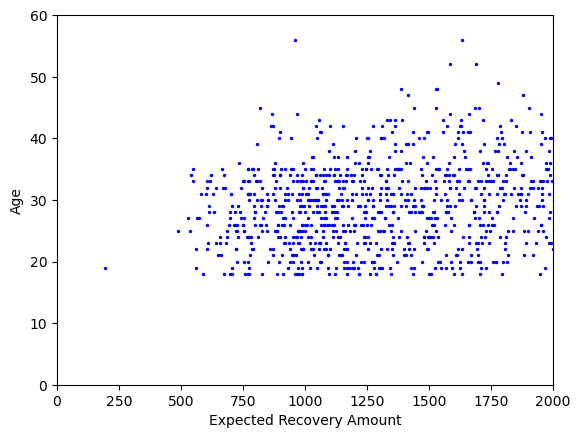

In [2]:
# Scatter plot of the age as a function of Expected Recovery Amount
%matplotlib inline
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="blue", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.show()

****Explanation:****
This code generates a scatter plot where the x-axis represents the 'Expected Recovery Amount,' the y-axis represents the 'Age,' and each data point is marked in blue with a size of 2. The plot is limited to x-axis values between 0 and 2000 and y-axis values between 0 and 60. Axes labels are provided for clarity.

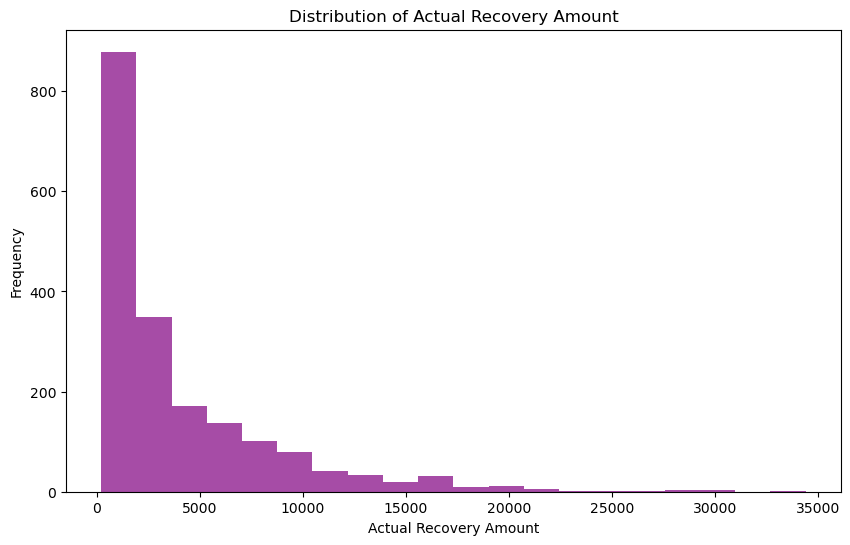

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(df['actual_recovery_amount'], bins=20, color='purple', alpha=0.7)
plt.title('Distribution of Actual Recovery Amount')
plt.xlabel('Actual Recovery Amount')
plt.ylabel('Frequency')
plt.show()

****Explanation:****
This code generates a histogram to visualize the distribution of 'Actual Recovery Amount' in the DataFrame. The histogram is plotted with 20 bins, colored in purple, and an alpha value of 0.7 for transparency. The title, x-axis label ('Actual Recovery Amount'), y-axis label ('Frequency'), and the plot itself are displayed in a figure with a size of 10 by 6 inches.

<IPython.core.display.Javascript object>

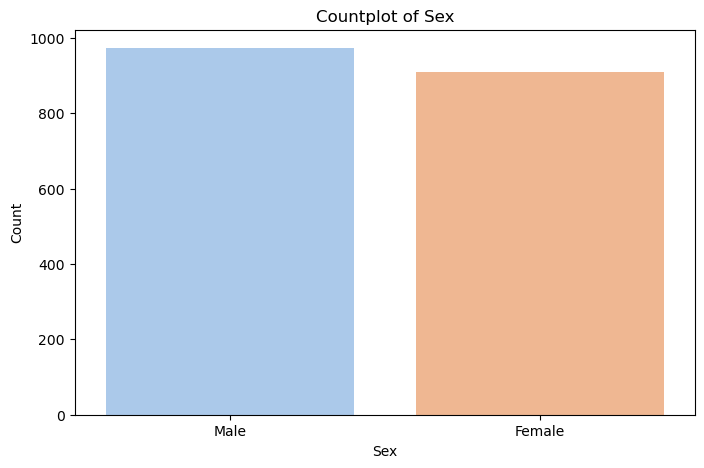

In [4]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sex', data=df, palette='pastel')
plt.title('Countplot of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

***Explanation:***
This code generates a count plot using Seaborn, illustrating the distribution of 'Sex' in the DataFrame. The figure is set to a size of 8 by 5 inches. The count plot visualizes the frequency of each category ('Male' and 'Female') on the x-axis, with pastel colors and a title, x-axis label ('Sex'), and y-axis label ('Count') for clarity.

### 3. Statistical test: age vs. expected recovery amount

We want to convince ourselves that variables such as age and sex are similar above and below the $1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.

The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around $1000. We will now do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from $900 to $1100.

For determining if there is a difference in the ages just above and just below the threshold, we will use the Kruskal-Wallis test, a statistical test that makes no distributional assumptions.

In [5]:
# Import stats module
from scipy import stats

# Compute average age just below and above the threshold
era_900_1100 = df.loc[(df['expected_recovery_amount'] < 1100) & 
                      (df['expected_recovery_amount'] >= 900)]

# Group by recovery strategy and describe the age distribution for each group
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
age_statistics = by_recovery_strategy['age'].describe().unstack()

# Print or analyze the age statistics for each recovery strategy
print("Age Statistics by Recovery Strategy:")
print(age_statistics)

# Perform Kruskal-Wallis test 
# Extract age data for Level 0 Recovery and Level 1 Recovery
Level_0_age = era_900_1100.loc[era_900_1100['recovery_strategy'] == "Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[era_900_1100['recovery_strategy'] == "Level 1 Recovery"]['age']

# Perform Kruskal-Wallis test on the age distributions for the two recovery strategies
kruskal_result = stats.kruskal(Level_0_age, Level_1_age)

# Print or analyze the result of the Kruskal-Wallis test
print("Kruskal-Wallis Test Result:")
print(kruskal_result)


Age Statistics by Recovery Strategy:
       recovery_strategy
count  Level 0 Recovery     89.000000
       Level 1 Recovery     94.000000
mean   Level 0 Recovery     27.224719
       Level 1 Recovery     28.755319
std    Level 0 Recovery      6.399135
       Level 1 Recovery      5.859807
min    Level 0 Recovery     18.000000
       Level 1 Recovery     18.000000
25%    Level 0 Recovery     23.000000
       Level 1 Recovery     24.000000
50%    Level 0 Recovery     26.000000
       Level 1 Recovery     29.000000
75%    Level 0 Recovery     31.000000
       Level 1 Recovery     33.000000
max    Level 0 Recovery     56.000000
       Level 1 Recovery     43.000000
dtype: float64
Kruskal-Wallis Test Result:
KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)


**Explanation:**
This code conducts a Kruskal-Wallis test to assess whether there are significant age differences between recovery strategies ("Level 0 Recovery" and "Level 1 Recovery") for cases with expected recovery amounts between 900 and 1100. The test compares the age distributions and prints the descriptive statistics along with the Kruskal-Wallis test result.

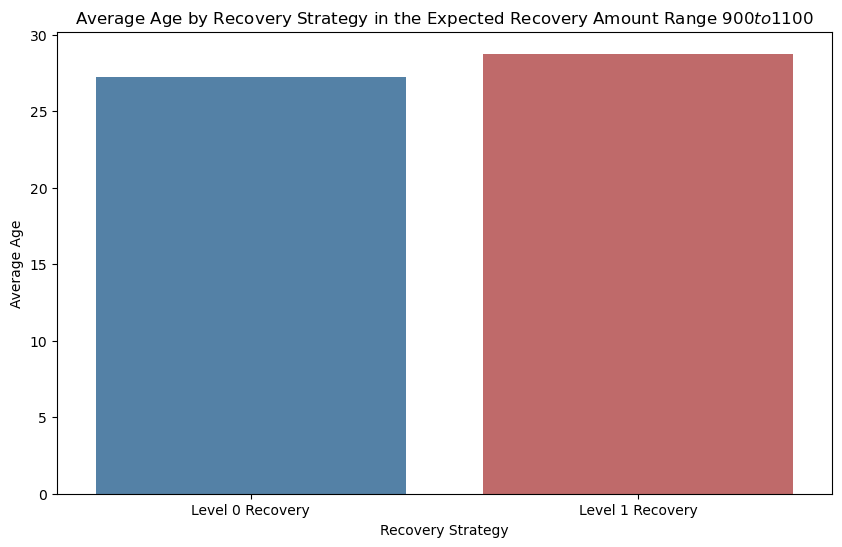

In [6]:
import seaborn as sns

# Define the age ranges just below and above the threshold
era_900_1100 = df.loc[(df['expected_recovery_amount'] < 1100) & (df['expected_recovery_amount'] >= 900)]

# Calculate the average age for each recovery strategy
average_age_by_strategy = era_900_1100.groupby('recovery_strategy')['age'].mean().reset_index()

# Define a custom color palette
custom_palette = ['steelblue', 'indianred']

# Create a bar chart with the custom color palette
plt.figure(figsize=(10, 6))
sns.barplot(x='recovery_strategy', y='age', data=average_age_by_strategy, palette=custom_palette)
plt.title('Average Age by Recovery Strategy in the Expected Recovery Amount Range $900 to $1100')
plt.xlabel('Recovery Strategy')
plt.ylabel('Average Age')
plt.show()

***Explanation:***
This code utilizes Seaborn to create a bar chart comparing the average age for each recovery strategy ("Level 0 Recovery" and "Level 1 Recovery") within the expected recovery amount range of $900 to $1100. The chart is customized with a specified color palette ('steelblue' for Level 0 and 'indianred' for Level 1), providing a visual representation of the average age differences between the two strategies.

### 4. Statistical test: sex vs. expected recovery amount

We want to convince ourselves that variables such as age and sex are similar above and below the $1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.
The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around $1000. We will be more confident in our conclusions if we do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from $900 to $1100.

In [7]:
# Number of customers in each category
# Create a cross-tabulation of recovery strategy and gender for customers with expected recovery amounts between 900 and 1100
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount'] < 1100) & 
                              (df['expected_recovery_amount'] >= 900)]['recovery_strategy'], 
                       df['sex'])

# Print the cross-tabulation
print("Cross-Tabulation of Recovery Strategy and Gender:")
print(crosstab)

# Chi-square test
# Perform the chi-square test on the cross-tabulated data
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)b

# Print the p-value resulting from the chi-square test
print("Chi-square Test p-value:")
print(p_val)


Cross-Tabulation of Recovery Strategy and Gender:
sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
Chi-square Test p-value:
0.5377947810444592


***Explanation:***
This code generates a cross-tabulation of recovery strategy and gender for customers with expected recovery amounts between 900 and 1100. It then performs a chi-square test to assess whether there is a statistically significant association between recovery strategy and gender within this specific range of expected recovery amounts. The p-value resulting from the chi-square test is printed, indicating the significance level of the association.

### 5. Exploratory graphical analysis: recovery amount

We are now reasonably confident that customers just above and just below the $1000 threshold are, on average, similar in terms of their average age and the percentage that are male.
It is now time to focus on the key outcome of interest, the actual recovery amount.
A first step in examining the relationship between the actual recovery amount and the expected recovery amount is to develop a scatter plot where we want to focus our attention at the range just below and just above the threshold. Specifically, we will develop a scatter plot of Expected Recovery Amount (Y) vs. Actual Recovery Amount (X) for Expected Recovery Amounts between $900 to $1100. This range covers Levels 0 and 1. A key question is whether or not we see a discontinuity (jump) around the $1000 threshold.

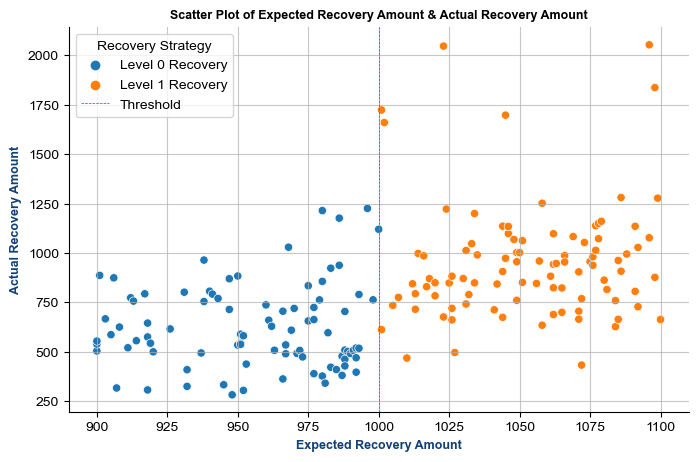

In [8]:

# Scatter plot of Expected Recovery Amount (Y) vs. Actual Recovery Amount(x)
# Filtering the data
threshold_range = (900, 1100)
filtered_df = df[(df['expected_recovery_amount'] >= threshold_range[0]) & (df['expected_recovery_amount'] <= threshold_range[1])]
# Creating a scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x='expected_recovery_amount', y='actual_recovery_amount', data=filtered_df, hue='recovery_strategy')
plt.axvline(x=1000, color='#ff006e', linestyle='--', linewidth=0.5, label='Threshold')
plt.title('Scatter Plot of Expected Recovery Amount & Actual Recovery Amount', fontdict={'fontsize' : 9, 'weight' : 'bold'})
plt.xlabel('Expected Recovery Amount', fontdict={'weight': 'bold', 'fontsize': 9, 'color': '#134074'})
plt.ylabel('Actual Recovery Amount', fontdict={'weight': 'bold', 'fontsize': 9, 'color': '#134074'})
plt.legend(title='Recovery Strategy')
plt.grid(True, alpha=0.7)
sns.set_style('darkgrid')
sns.despine()
plt.show()


***Explanation:***
This code generates a scatter plot comparing 'Expected Recovery Amount' (x-axis) and 'Actual Recovery Amount' (y-axis) for data points within the specified threshold range of 900 to 1100. The points are color-coded based on the 'Recovery Strategy,' and a vertical dashed line is added at the threshold value of 1000. The plot is styled with custom colors, labels, and a legend to highlight the relationship between expected and actual recovery amounts for different recovery strategies.

### 6. Statistical analysis: recovery amount

Just as we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the $1000 threshold. We are going to do this for two different windows of the expected recovery amount $900 to $1100 and for a narrow range of $950 to $1050 to see if our results are consistent.
Again, the statistical test we will use is the Kruskal-Wallis test, a test that makes no assumptions about the distribution of the actual recovery amount.

In [9]:
# Compute average actual recovery amount just below and above the threshold
# Group by recovery strategy and describe the actual recovery amount for each group
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test for the range $900 to $1100
# Extract actual recovery amount data for Level 0 Recovery and Level 1 Recovery
Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']

# Perform Kruskal-Wallis test on the actual recovery amounts for the two recovery strategies
stats.kruskal(Level_0_actual, Level_1_actual)

# Repeat for a smaller range of $950 to $1050
era_950_1050 = df.loc[(df['expected_recovery_amount'] < 1050) & 
                      (df['expected_recovery_amount'] >= 950)]

# Extract actual recovery amount data for Level 0 Recovery and Level 1 Recovery in the smaller range
Level_0_actual = era_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']

# Perform Kruskal-Wallis test on the actual recovery amounts for the two recovery strategies in the smaller range
stats.kruskal(Level_0_actual, Level_1_actual)


KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

***Explanation:***
The code calculates descriptive statistics for 'Actual Recovery Amount' by 'Recovery Strategy' in the ranges $900 to $1100 and $950 to $1050. Kruskal-Wallis tests are performed to determine if significant differences exist in actual recovery amounts between 'Level 0 Recovery' and 'Level 1 Recovery' strategies within each specified range, aiding the assessment of strategy effectiveness within distinct expected recovery amount intervals.

### 7. Regression modeling: no threshold

We now want to take a regression-based approach to estimate the impact of the program at the $1000 threshold using the data that is just above and just below the threshold. In order to do that, we will build two models. The first model does not have a threshold while the second model will include a threshold.
The first model predicts the actual recovery amount (outcome or dependent variable) as a function of the expected recovery amount (input or independent variable). We expect that there will be a strong positive relationship between these two variables.

In [10]:
# Import statsmodels
import statsmodels.api as sm

# Define X and y
X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']

# Add a constant term to X
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()

# Generate predictions using the model
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):           1.56e-13
Time:                            10:18:19   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***Explanation***
This code employs the statsmodels library to conduct a simple linear regression analysis. It defines 'X' as the 'Expected Recovery Amount' and 'y' as the 'Actual Recovery Amount' for the specified range of expected recovery amounts ($900 to $1100). A constant term is added to 'X,' and a linear regression model is built. The model summary statistics, including coefficients, significance levels, and goodness-of-fit measures, are then printed.

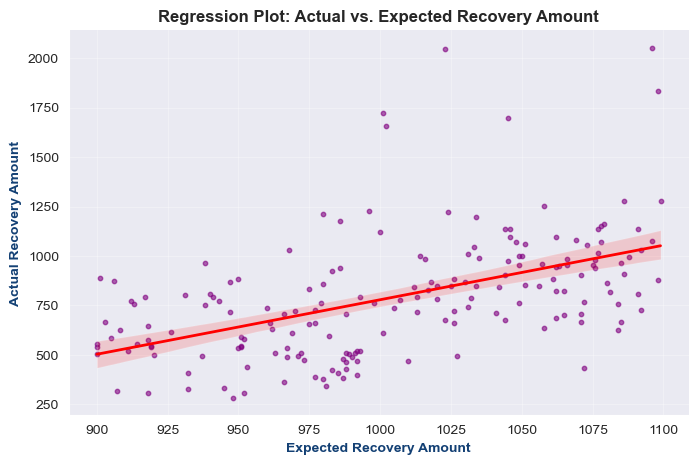

In [11]:
import seaborn as sns

# Define X and y
X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']

# Add a constant term to X
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()

# Generate predictions using the model
predictions = model.predict(X)

# Create a regression plot with different colors for Actual and Expected
plt.figure(figsize=(8, 5))
sns.regplot(x=X.iloc[:, 1], y=y, scatter_kws={'s': 10, 'alpha': 0.6}, line_kws={'color': 'red', 'linewidth': 2}, color='purple')

plt.title('Regression Plot: Actual vs. Expected Recovery Amount', fontdict={'fontsize': 12, 'weight': 'bold'})
plt.xlabel('Expected Recovery Amount', fontdict={'weight': 'bold', 'fontsize': 10, 'color': '#134074'})
plt.ylabel('Actual Recovery Amount', fontdict={'weight': 'bold', 'fontsize': 10, 'color': '#134074'})
plt.grid(True, alpha=0.3)
sns.set_style('darkgrid')
sns.despine()
plt.show()


***Explanation:***
This code uses seaborn to create a regression plot comparing 'Actual Recovery Amount' with 'Expected Recovery Amount' for the specified range ($900 to $1100). The plot includes different colors for the actual data points (in purple) and the regression line (in red). The figure is styled with a title, axis labels, and a grid for better visualization of the relationship between actual and expected recovery amounts.

### 8. Regression modeling: adding true threshold

From the first model, we see that the regression coefficient is statistically significant for the expected recovery amount and the adjusted R-squared value was about 0.26. As we saw from the graph, on average the actual recovery amount increases as the expected recovery amount increases. We could add polynomial terms of expected recovery amount (such as the squared value of expected recovery amount) to the model but, for the purposes of this practice, let's stick with using just the linear term.
The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.

In [12]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount'] < 1000, 0, 1)

# Filter data for expected recovery amounts between $900 and $1100
era_900_1100 = df.loc[(df['expected_recovery_amount'] < 1100) & 
                      (df['expected_recovery_amount'] >= 900)]

# Define X and y
# X includes both 'expected_recovery_amount' and 'indicator_1000' as independent variables
X = era_900_1100[['expected_recovery_amount', 'indicator_1000']]
y = era_900_1100['actual_recovery_amount']

# Add a constant term to X
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):           1.83e-15
Time:                            10:18:19   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***Explanation:***
This code creates a binary indicator variable ('indicator_1000') based on whether 'Expected Recovery Amount' is greater than or equal to $1000. It then filters the data for expected recovery amounts between $900 and $1100 and defines 'X' with both 'Expected Recovery Amount' and the binary indicator as independent variables. The linear regression model is built with 'Actual Recovery Amount' as the dependent variable. The model summary, including coefficients and statistical information, is printed. The indicator variable helps assess the impact of being above or below the $1000 threshold on actual recovery amounts.

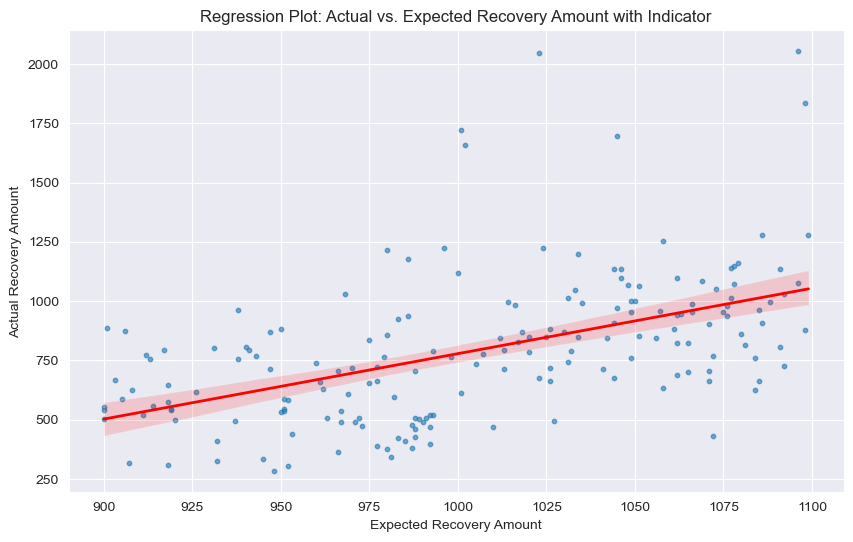

In [13]:
import seaborn as sns

# Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount'] < 1000, 0, 1)

# Filter data for expected recovery amounts between $900 and $1100
era_900_1100 = df.loc[(df['expected_recovery_amount'] < 1100) & 
                      (df['expected_recovery_amount'] >= 900)]

# Define X and y
# X includes both 'expected_recovery_amount' and 'indicator_1000' as independent variables
X = era_900_1100[['expected_recovery_amount', 'indicator_1000']]
y = era_900_1100['actual_recovery_amount']

# Add a constant term to X
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()

# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(x='expected_recovery_amount', y='actual_recovery_amount', data=era_900_1100, scatter_kws={'s': 10, 'alpha': 0.6}, line_kws={'color': 'red', 'linewidth': 2})

# Set labels and title
plt.title('Regression Plot: Actual vs. Expected Recovery Amount with Indicator')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')

# Show the plot
plt.show()


***Explanation:***
This code creates a binary indicator variable ('indicator_1000') based on whether 'Expected Recovery Amount' is greater than or equal to $1000. It then filters the data for expected recovery amounts between $900 and $1100, defines 'X' with both 'Expected Recovery Amount' and the binary indicator as independent variables, and builds a linear regression model with 'Actual Recovery Amount' as the dependent variable. The resulting regression plot visualizes the relationship between 'Expected Recovery Amount' and 'Actual Recovery Amount' for this specific range, with a red regression line. The scatter points are transparent, allowing for a clearer view of the data distribution.

### 9. Regression modeling: adjusting the window

The regression coefficient for the true threshold was statistically significant with an estimated impact of around $278 and a 95 percent confidence interval of $132 to $424. This is much larger than the incremental cost of running the higher recovery strategy which was $50 per customer. At this point, we are feeling reasonably confident that the higher recovery strategy is worth the additional costs of the program for customers just above and just below the threshold.

In [14]:
# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = df.loc[(df['expected_recovery_amount'] < 1050) & 
                      (df['expected_recovery_amount'] >= 950)]

# Define X and y 
# X includes both 'expected_recovery_amount' and 'indicator_1000' as independent variables
X = era_950_1050[['expected_recovery_amount', 'indicator_1000']]
y = era_950_1050['actual_recovery_amount']

# Add a constant term to X
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):           1.12e-07
Time:                            10:18:20   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***Explanation:***
This code redefines a subset of the data ('era_950_1050') with expected recovery amounts between $950 and $1050, including the binary indicator variable ('indicator_1000'). It then defines 'X' with both 'Expected Recovery Amount' and the binary indicator as independent variables and 'y' as the 'Actual Recovery Amount.' A constant term is added to 'X,' and a linear regression model is built. The model summary, displaying coefficients, statistical information, and goodness-of-fit measures, is then printed. This analysis provides insights into the relationship between 'Expected Recovery Amount,' the indicator variable, and 'Actual Recovery Amount' within the narrower expected recovery amount range.

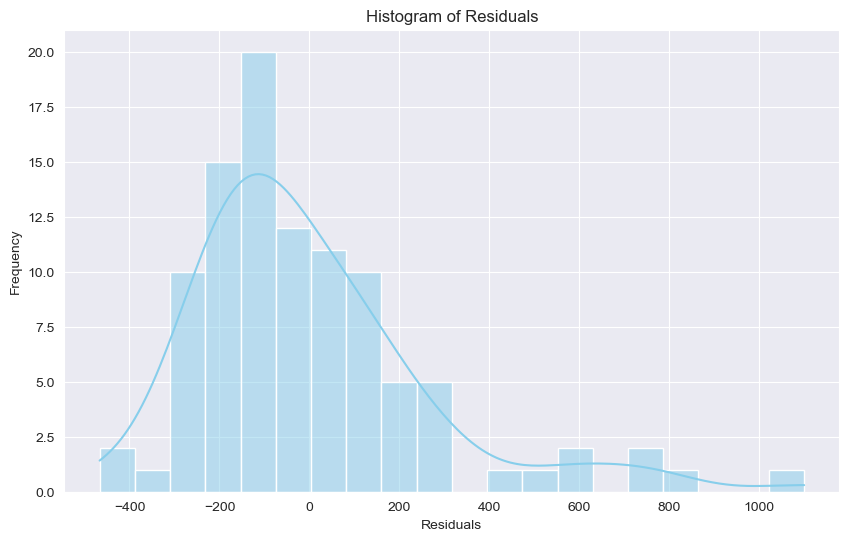

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = df.loc[(df['expected_recovery_amount'] < 1050) & 
                      (df['expected_recovery_amount'] >= 950)]

# Define X and y 
# X includes both 'expected_recovery_amount' and 'indicator_1000' as independent variables
X = era_950_1050[['expected_recovery_amount', 'indicator_1000']]
y = era_950_1050['actual_recovery_amount']

# Add a constant term to X
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()

# Calculate residuals
residuals = y - model.predict(X)

# Create a histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=20, kde=True, color='skyblue')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


***Explanation:***
The code begins by defining a subset of the data focused on expected recovery amounts between $950 and $1050 (`era_950_1050`). It then constructs a linear regression model using the expected recovery amounts and an indicator variable. The model's residuals, representing the differences between predicted and actual recovery amounts, are computed. Finally, a histogram with kernel density estimation is created to visualize the distribution of these residuals, offering insights into the model's predictive performance and potential patterns in prediction errors.